# NNS

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform

In [2]:
ratings = pd.read_csv('ratings.csv')

In [3]:
# Train-test split
ntestusers = 100
testusers = np.random.choice(ratings['userId'].unique(), size=ntestusers)

test = ratings[ratings['userId'].isin(testusers)]

train = ratings[ratings['userId'].isin(testusers) == False]

ratingspercent = 25 # Train ratings

for i in test['userId'].unique():
    df = test[test['userId'] == i]
    
    ntrainratings = int(np.round(df.shape[0] * ratingspercent / 100))
    trainratings = np.random.choice(test[test['userId'] == i]['movieId'], size=ntrainratings)
    
    train = pd.concat((train, test[((test['userId'] == i) & (test['movieId'].isin(trainratings)))]))
    test = test[((test['userId'] == i) & (test['movieId'].isin(trainratings))) == False]

In [4]:
def NNSrecommend(inputuser = 1, ratings=ratings):
    
    """Suggest movies based on NNS algorihm.
    
    Input:
    inputuser       -- "userId" of the selected user
    
    Output:
    recommendations -- "movieId"-s of recommended movies, numpy.ndarray format
    
    Error codes:
    -1              -- "inputuser" not found in database
    -2              -- There are no users, that have rated the same movies
    """
    
    if inputuser not in ratings['userId'].unique():
        return -1

    # Reduction of movies
    seenmovies = ratings[ratings['userId'] == inputuser]['movieId']
    smallratings = ratings[ratings['movieId'].isin(seenmovies)]

    # Reduction of users
    users = smallratings['userId'].value_counts() == len(seenmovies)
    users = users.index[users].tolist()
    smallratings = smallratings[smallratings['userId'].isin(users)]
        
    # Make pivot table and calculate distances
    table = pd.pivot_table(smallratings, values='rating', index='userId', columns='movieId')

    distances = pdist(table, metric='euclidean')
    distances = squareform(distances)
    
    # Select the distances that we need
    distances = pd.DataFrame(index = table.index, columns = table.index, data = distances)
    distances = distances[distances.index == inputuser].drop(inputuser, axis = 1)
    
    if distances.empty:
        return -2
    
    nearestuser = distances.idxmin(axis = 1).values[0]

    recommendations = ratings[(ratings['userId'] == nearestuser) & (ratings['movieId'].isin(seenmovies) == False)
                              & (ratings['rating'] >= 4)]['movieId'].values
    
    return recommendations

In [5]:
confmatrix = np.zeros((2,2))

In [6]:
confmatrix

array([[0., 0.],
       [0., 0.]])

In [7]:
for userid in test['userId'].unique():
    if sum(train['userId'] == userid) < 10: # Less than 10 ratings in train
        continue
        
    recommended = NNSrecommend(userid, train)
    
    if type(recommended) == int:
        continue
        
    for movieid in ratings['movieId'].unique():
        if test[(test['userId'] == userid) & (test['movieId'] == movieid)].shape[0] == 0 or test[(test['userId'] == userid) & (test['movieId'] == movieid)].iloc[0]['rating'] < 2.5: # Actual no
            if movieid in recommended: # Predicted yes
                confmatrix[0,1] = confmatrix[0,1] + 1 # False positive
            else: # Predicted no
                confmatrix[0,0] = confmatrix[0,0] + 1 # True negative
                
        else: # Actual yes
            if movieid in recommended: # Predicted yes
                confmatrix[1,1] = confmatrix[1,1] + 1 # True positive
            else: # Predicted no
                confmatrix[1,0] = confmatrix[1,0] + 1 # False negative
                

In [8]:
confmatrix

array([[1.231593e+06, 2.984000e+04],
       [9.620000e+02, 8.250000e+02]])

In [9]:
# Accuracy
( confmatrix[0,0] + confmatrix[1,1] ) / np.sum(confmatrix)

0.9756162821994585

In [10]:
# Precision
confmatrix[1,1] / (confmatrix[0,1] + confmatrix[1,1])

0.026903636067177564

In [11]:
# Recall
confmatrix[1,1] / (confmatrix[1,0] + confmatrix[1,1])

0.4616675993284835

# Global movie recommender

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler

from kmodes.kprototypes import KPrototypes

import time
import pickle

In [13]:
movies = pd.read_csv('4 movies.csv')
unprepared_movies = pd.read_csv('4 movies.csv')
country_codes = pd.read_csv('country_codes.csv')
ratings = pd.read_csv('2 ratings.csv')

In [14]:
def get_numbers(str):
    """Return the integer numbers from a string in an array format."""
    arr = str.replace(',','').replace('{','').replace('}','').replace('[','').replace(']','').split()
    arr = [int(s) for s in arr if s.isdigit()]
    return arr

def get_country_codes(str):
    """Return the codes of the countries from a string."""
    arr = str.replace(',','').replace('{','').replace('}','').replace('[','').replace(']','').replace("'", "").split()
    arr = [s for s in arr if country_codes['Code'].str.contains(s).any()]
    return arr

def prepare_dataframe(movies):
    
    # Conversion
    movies['genres'] = movies['genres'].apply(lambda str: get_numbers(str))
    movies['production_companies'] = movies['production_companies'].apply(lambda str: get_numbers(str))
    movies['production_countries'] = movies['production_countries'].apply(lambda str: get_country_codes(str)) # This takes time
    
    # Get dummies
    mlb = MultiLabelBinarizer()
    genres = pd.DataFrame(mlb.fit_transform(movies['genres']), columns=mlb.classes)

    mlb = MultiLabelBinarizer()
    production_companies = pd.DataFrame(mlb.fit_transform(movies['production_companies']), columns=mlb.classes)

    mlb = MultiLabelBinarizer()
    production_countries = pd.DataFrame(mlb.fit_transform(movies['production_countries']), columns=mlb.classes)

    original_language = pd.get_dummies(movies['original_language'])
    
    # Rename the columns to unique names
    for i in range(genres.shape[1]):
        genres.rename(mapper={i : str(i) + '. genre'}, axis=1, inplace=True)
    
    for i in range(production_countries.shape[1]):
        production_countries.rename(mapper={i : str(i) + '. country'}, axis=1, inplace=True)
    
    movieids = movies['id']
    movies = movies.drop(['id', 'title'], axis=1)
    
    # production_companies, original languages, production countries are not used, because of huge running time
    numeric = movies.drop(['adult', 'genres', 'original_language', 'production_companies', 'production_countries'], axis=1)
    categorical = movies[['adult']].join(genres)
    
    # Scale the numeric values to (0, 1) interval
    scaler = MinMaxScaler()
    numeric = scaler.fit_transform(numeric)
    
    movievectors = pd.DataFrame(numeric).join(categorical)
    movievectors.index = movieids
    
    return movievectors

def convert_title_to_index(x):
    row = unprepared_movies2[unprepared_movies2['title'] == x]
    return np.array(row['id'])[0]

In [15]:
movies = prepare_dataframe(movies)

In [16]:
kproto = pickle.load(open("kproto_4000.p", "rb"))
all_movies_clusters = pickle.load(open("clusters_kproto_4000.p", "rb"))

In [17]:
def recommend_movies(uid, unprepared_movies, movies, ratings, cluster_obj, clusters):
    """
    Input:
    uid - ID of the user
    
    Output:
    potential_suggestions - The most popular 20 suggested movies
    
    Error codes:
    -1 - This userID does not exist
    -2 - There are no movies in the current form of movies database that was rated by the user
    """
    
    rated_movies = ratings[ratings['userId'] == uid].drop('userId', axis=1)

    if rated_movies.shape[0] == 0:
        return -1 # Invalid userId

    best_match = find_best_matching_cluster(uid, movies, rated_movies, cluster_obj)
    
    if best_match == -2:
        return -2 # There is no rated movie in movies database

    # Select the movies in the best matching cluster
    potential_suggestions = unprepared_movies[unprepared_movies['id'].isin(movies[clusters == best_match].index)]

    # Delete previously watched (rated) movies
    watched_index = potential_suggestions[potential_suggestions['id'].isin(rated_movies['movieId'])].index
    potential_suggestions = potential_suggestions.drop(watched_index)

    # First suggest the more popular movies
    potential_suggestions = potential_suggestions.sort_values('popularity', ascending=False)

    # Grab the first twenty
    potential_suggestions = potential_suggestions['title'].head(20)
    
    return potential_suggestions

def find_best_matching_cluster(uid, movies, rated_movies, cluster_obj):
    # The clusters of movies that have been rated at least once
    clusters = np.array([])
    
    # The indexes of movies that have not been found in movies database
    # Which indicates error in data set
    indexlist = np.array([])
    
    for index, row in rated_movies.iterrows():
        try:
            clusters = np.append(clusters, cluster_obj.predict(pd.DataFrame(movies.loc[int(row['movieId'])]).transpose(), categorical=[i for i in range(57,movies.shape[1])]))
        except:
            indexlist = np.append(indexlist, index)
    
    # Handle inconsistency in DB
    rated_movies.drop(indexlist, inplace=True)

    rated_movies['clusters'] = clusters

    # Find the highest rated cluster
    if rated_movies.shape[0] > 0:
        best_match = rated_movies[['rating', 'clusters']].groupby('clusters').mean().idxmax()[0]
    else:
        return -2 # There is no rated movie in movies database
    
    return best_match

In [18]:
# Train-test split
ntestusers = 100
testusers = np.random.choice(ratings['userId'].unique(), size=ntestusers)

test = ratings[ratings['userId'].isin(testusers)]

train = ratings[ratings['userId'].isin(testusers) == False]

ratingspercent = 25 # Train ratings

for i in test['userId'].unique():
    df = test[test['userId'] == i]
    
    ntrainratings = int(np.round(df.shape[0] * ratingspercent / 100))
    trainratings = np.random.choice(test[test['userId'] == i]['movieId'], size=ntrainratings)
    
    train = pd.concat((train, test[((test['userId'] == i) & (test['movieId'].isin(trainratings)))]))
    test = test[((test['userId'] == i) & (test['movieId'].isin(trainratings))) == False]

In [19]:
confmatrix = np.zeros((2,2))

In [20]:
confmatrix

array([[0., 0.],
       [0., 0.]])

In [21]:
for userid in test['userId'].unique():
    if sum(train['userId'] == userid) < 10: # Less than 10 ratings in train
        continue
        
    recommended = recommend_movies(userid, unprepared_movies, movies, train, kproto, all_movies_clusters)
    
    if type(recommended) == int:
        continue
        
    for movieid in ratings['movieId'].unique():
        if test[(test['userId'] == userid) & (test['movieId'] == movieid)].shape[0] == 0 or test[(test['userId'] == userid) & (test['movieId'] == movieid)].iloc[0]['rating'] < 2.5: # Actual no
            if movieid in recommended.index: # Predicted yes
                confmatrix[0,1] = confmatrix[0,1] + 1 # False positive
            else: # Predicted no
                confmatrix[0,0] = confmatrix[0,0] + 1 # True negative
                
        else: # Actual yes
            if movieid in recommended.index: # Predicted yes
                confmatrix[1,1] = confmatrix[1,1] + 1 # True positive
            else: # Predicted no
                confmatrix[1,0] = confmatrix[1,0] + 1 # False negative
                

In [22]:
confmatrix

array([[1.90717e+05, 7.30000e+01],
       [2.30900e+03, 3.00000e+00]])

In [23]:
# Accuracy
( confmatrix[0,0] + confmatrix[1,1] ) / np.sum(confmatrix)

0.9876645503412704

In [24]:
# Precision
confmatrix[1,1] / (confmatrix[0,1] + confmatrix[1,1])

0.039473684210526314

In [25]:
# Recall
confmatrix[1,1] / (confmatrix[1,0] + confmatrix[1,1])

0.0012975778546712802

# Bi-clustering recommendation

In [26]:
import pandas as pd
import numpy as np
import random
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import Birch
from sklearn.decomposition import PCA

import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
ratings = pd.read_csv("4 ratings_bicluster2.csv")
movies = pd.read_csv("5 movies_bicluster.csv", low_memory=False)
nuserClusters = ratings.userCluster.nunique()
nmovieClusters = ratings.movieCluster.nunique()

In [28]:
def mutual_information(ratings, nmovieClusters, nuserClusters):
    
    # Joint distribution
    relationMatrix = np.zeros((nmovieClusters,nuserClusters))
    for i in range(nmovieClusters):
        for j in range (nuserClusters):
            relationMatrix[i,j] = ratings[(ratings['movieCluster'] == i) & 
                                      (ratings['userCluster'] == j)].shape[0] / ratings.shape[0]
            
    # Mutual information
    M = 0
    for i in range(nmovieClusters):
        for j in range (nuserClusters):
            M = M + relationMatrix[i,j] * np.log2(relationMatrix[i,j] / np.sum(relationMatrix, axis=0)[j] / np.sum(relationMatrix, axis=1)[i])
                
    return M

In [29]:
def hill_climbing_mutual_information_score(ratings, nmovieClusters, nuserClusters, minutes):
    
    scores = []
    localscore = mutual_information(ratings, nmovieClusters, nuserClusters)
    scores.append(localscore)
    random_factor = ratings['userId'].nunique() / (ratings['movieId'].nunique() + ratings['userId'].nunique())
    start = time.time()
    
    #for nIterations in range(1):
    while time.time() - start < minutes * 60: # time in seconds
        if np.random.rand() > random_factor:
            random_movie_id = random.choice(ratings.movieId.unique())
            random_movie_cluster = np.random.randint(0, nmovieClusters)
            ratings2 = ratings.copy(deep = True)
            ratings2.loc[ratings2.movieId == random_movie_id, 'movieCluster'] = random_movie_cluster

            neighborscore = mutual_information(ratings2, nmovieClusters, nuserClusters)    
        else:
            random_user_id = random.choice(ratings.userId.unique())
            random_user_cluster = np.random.randint(0, nuserClusters)
            ratings2 = ratings.copy(deep = True)
            ratings2.loc[ratings2.userId == random_user_id, 'userCluster'] = random_user_cluster

            neighborscore = mutual_information(ratings2, nmovieClusters, nuserClusters) 
        
        scores.append(neighborscore)
        
        if neighborscore > localscore:
            ratings = ratings2.copy(deep = True)
            localscore = neighborscore
            
    return ratings, scores

In [30]:
# Train-test split
ntestusers = 100
testusers = np.random.choice(ratings['userId'].unique(), size=ntestusers)

test = ratings[ratings['userId'].isin(testusers)]

train = ratings[ratings['userId'].isin(testusers) == False]

ratingspercent = 25 # Train ratings

for i in test['userId'].unique():
    df = test[test['userId'] == i]
    
    ntrainratings = int(np.round(df.shape[0] * ratingspercent / 100))
    trainratings = np.random.choice(test[test['userId'] == i]['movieId'], size=ntrainratings)
    
    train = pd.concat((train, test[((test['userId'] == i) & (test['movieId'].isin(trainratings)))]))
    test = test[((test['userId'] == i) & (test['movieId'].isin(trainratings))) == False]

In [31]:
[train, scores] = hill_climbing_mutual_information_score(train, nmovieClusters, nuserClusters, minutes=15)

In [32]:
def bi_clustering_recommender(uid, ratings, movies):
    """
    Input:
    uid - ID of the user
    ratings - DataFrame that contains the ratings in a special structure
    movies - DataFrame that contains the movies in a special structure
    
    Output:
    suggested_movies - The most popular 'k' suggested movies
    
    Error codes:
    -1 - The user has no ratings
    """
    
    k = 20 # Number of suggested movies
    
    if sum(ratings['userId'] == uid) == 0:
        return -1
        
    # Joint distribution
    nmovieClusters = ratings['movieCluster'].nunique()
    nuserClusters = ratings['userCluster'].nunique()
    relationMatrix = np.zeros((nmovieClusters,nuserClusters))
    
    for i in range(nmovieClusters):
        for j in range (nuserClusters):
            relationMatrix[i,j] = ratings[(ratings['movieCluster'] == i) & 
                                      (ratings['userCluster'] == j)].shape[0] / ratings.shape[0]
    
    # Relation's of the given user's cluster
    relations = relationMatrix[:, ratings[ratings['userId'] == uid]['userCluster'].iloc[0] ]
    best_movie_cluster = np.argmax(relations)
    
    indexes_in_best_cluster = ratings[ratings['movieCluster'] == best_movie_cluster]['movieId'].unique()
    watched_movies_indexes = ratings[ratings['userId'] == uid]['movieId']
    
    suggested_movies = movies[['id', 'popularity', 'title']]
    suggested_movies = suggested_movies[suggested_movies['id'].isin(indexes_in_best_cluster)]
    suggested_movies = suggested_movies[suggested_movies['id'].isin(watched_movies_indexes) == False]
    suggested_movies = suggested_movies.sort_values('popularity', ascending=False)
    
    return suggested_movies.head(k)['title']

In [33]:
confmatrix = np.zeros((2,2))

In [34]:
confmatrix

array([[0., 0.],
       [0., 0.]])

In [35]:
for userid in test['userId'].unique():
    if sum(train['userId'] == userid) < 10: # Less than 10 ratings in train
        continue
        
    recommended = bi_clustering_recommender(userid, train, movies)
    
    if type(recommended) == int:
        continue
        
    for movieid in ratings['movieId'].unique():
        if test[(test['userId'] == userid) & (test['movieId'] == movieid)].shape[0] == 0 or test[(test['userId'] == userid) & (test['movieId'] == movieid)].iloc[0]['rating'] < 2.5: # Actual no
            if movieid in recommended.index: # Predicted yes
                confmatrix[0,1] = confmatrix[0,1] + 1 # False positive
            else: # Predicted no
                confmatrix[0,0] = confmatrix[0,0] + 1 # True negative
                
        else: # Actual yes
            if movieid in recommended.index: # Predicted yes
                confmatrix[1,1] = confmatrix[1,1] + 1 # True positive
            else: # Predicted no
                confmatrix[1,0] = confmatrix[1,0] + 1 # False negative
                

In [36]:
confmatrix

array([[1.53216e+05, 2.93000e+02],
       [2.28200e+03, 1.30000e+01]])

In [37]:
# Accuracy
( confmatrix[0,0] + confmatrix[1,1] ) / np.sum(confmatrix)

0.9834728248311981

In [38]:
# Precision
confmatrix[1,1] / (confmatrix[0,1] + confmatrix[1,1])

0.042483660130718956

In [39]:
# Recall
confmatrix[1,1] / (confmatrix[1,0] + confmatrix[1,1])

0.005664488017429194

# Plots

In [59]:
accuracy = pd.DataFrame()
accuracy['Method'] = ('Naive recommendation (NNS)', 'Global recommendation', 'Bi-clustering recommendation')
accuracy['Value'] = (0.9756162821994585, 0.9876645503412704, 0.9834728248311981)

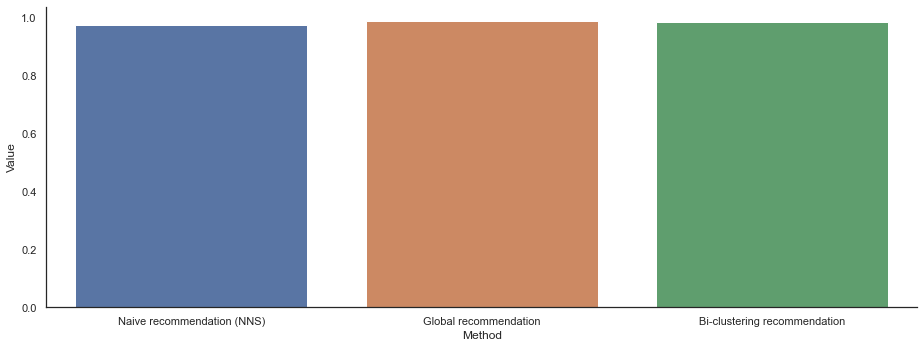

In [60]:
sns.set_theme(style="white")

sns.catplot(data=accuracy, x='Method', y='Value', kind='bar', height=5, aspect=13/5)

In [61]:
precision = pd.DataFrame()
precision['Method'] = ('Naive recommendation (NNS)', 'Global recommendation', 'Bi-clustering recommendation')
precision['Value'] = (0.026903636067177564, 0.039473684210526314, 0.042483660130718956)

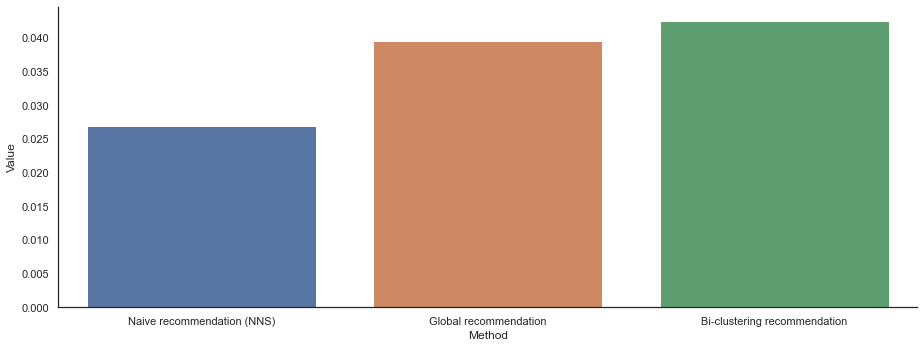

In [62]:
sns.set_theme(style="white")

sns.catplot(data=precision, x='Method', y='Value', kind='bar', height=5, aspect=13/5)

In [63]:
recall = pd.DataFrame()
recall['Method'] = ('Global recommendation', 'Bi-clustering recommendation')
recall['Value'] = (0.0012975778546712802, 0.005664488017429194)

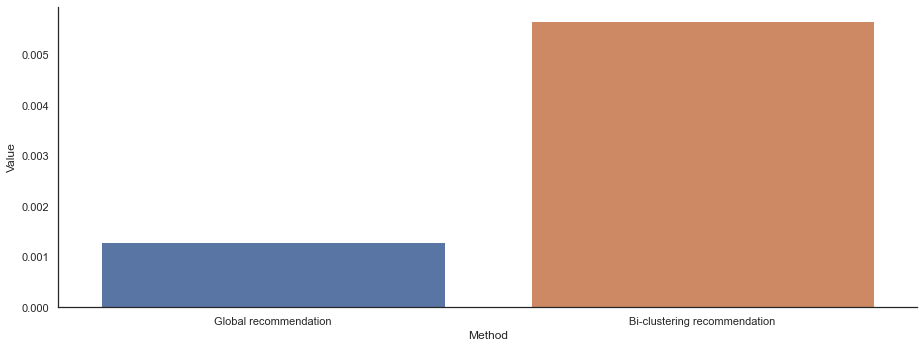

In [64]:
sns.set_theme(style="white")

sns.catplot(data=recall, x='Method', y='Value', kind='bar', height=5, aspect=13/5)

In [69]:
f1 = pd.DataFrame()
f1['Method'] = ('Global recommendation', 'Bi-clustering recommendation')
f1['Value'] = (2 * 0.039473684210526314 * 0.0012975778546712802 / (0.039473684210526314 + 0.0012975778546712802),
               2 * 0.042483660130718956 * 0.005664488017429194 / (0.042483660130718956 + 0.005664488017429194) )

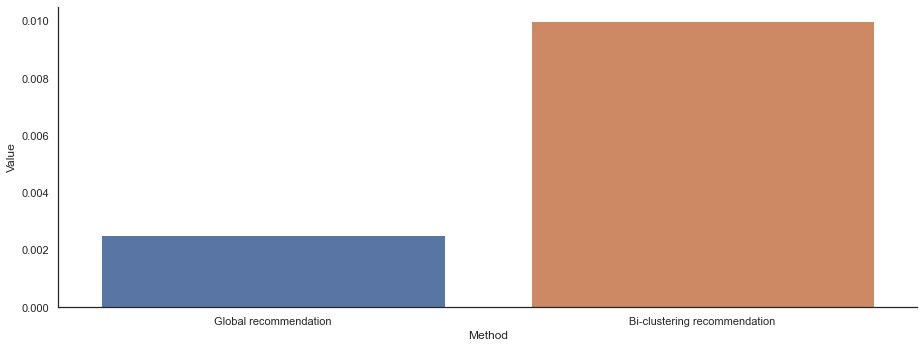

In [70]:
sns.set_theme(style="white")

sns.catplot(data=f1, x='Method', y='Value', kind='bar', height=5, aspect=13/5)